In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.pooling import MaxPool2d
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from numpy.core.fromnumeric import reshape
import torch.nn.functional as F
import collections
from typing import Any, Callable, cast, Dict, List, Optional, Tuple
from typing import Union

Setting the parameters for the datasets.

In [ ]:
# Root directory for dataset
train_dataroot = "/content/drive/MyDrive/DL_Notebooks/data/train/train/"
test_dataroot = "/content/drive/MyDrive/DL_Notebooks/data/test/test/unlabelled/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# # Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Creating a custome dataset function in order to load the training and testing image set. A boolean option known as train has been used , in order to signal the function if the image set being passed is of training type or testing type. The class labels have also been filtered an annotated in the same function.

In [ ]:
import os
import glob
import pandas as pd
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import PIL
import torch
import torchvision.transforms as transforms
import torchvision

class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None,train=True):
      self.imgs_path = root
      self.transform = transform
      self.train = train
      self.data = []
      self.result = []
      file_list = glob.glob(self.imgs_path + "*")
      if self.train == True:
        self.labels = [class_path.split("/")[-1] for class_path in file_list]
        self.labels_to_id = { v:i for i,v in enumerate(self.labels)}
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.png"):
                self.data.append([img_path, self.labels_to_id[class_name]])
      else:
        for path in file_list:
          self.data.append(path)
 
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      if self.train == True:
        img_path, label = self.data[idx]
        image=cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if self.transform:
          image=self.transform(image)
        self.result = [image,label,idx,img_path]
        return self.result
      else:
        img_path = self.data[idx]
        image=cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if self.transform:
          image=self.transform(image)
        self.result = [image,idx,img_path]
        return self.result

Creating a label transformer. This function inputs a value within the ange of (0,1,2,3) and produces the corresponding label for output. The function is being used for later to reproduce the label names from predictions on the test dataset.

In [ ]:

def target_transform_label(target):
    length = len(target)
    result = np.array([])
    for i in range(0,len(target)):
        item = target[i]
        if item==1:
            result=np.append(result,["Immune"])
        elif item==2:
            result=np.append(result,["Normal"])
        elif item ==3:
            result=np.append(result,["Cancer"])
        elif item==0:
            result=np.append(result,["Connective"])
    return result

Loading the datasets while applying some transformer functions and converting into a dataloader object based on the batch size set above. 

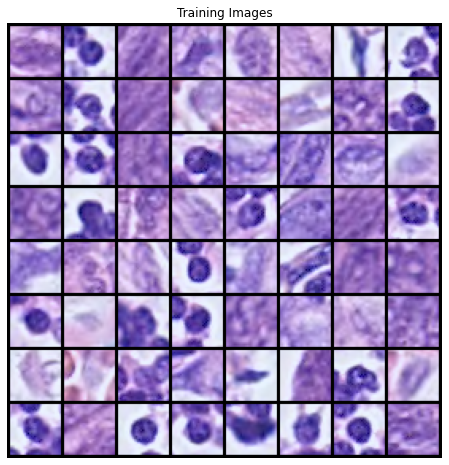

In [ ]:
train_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                ])

train_dataset = CustomImageDataset(train_dataroot,train=True,transform=train_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)


# Plot some training images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

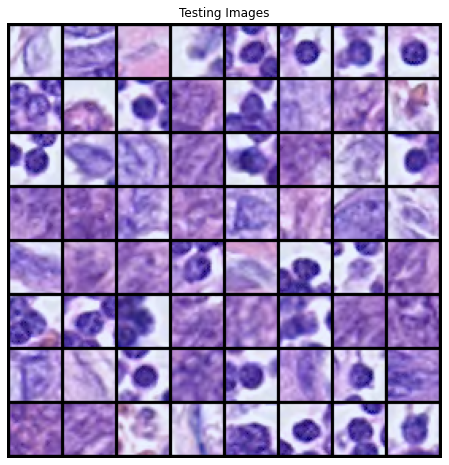

In [ ]:
test_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                ])

test_dataset = CustomImageDataset(test_dataroot,train=False,transform=test_transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some testing images
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Testing Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


Creating an intital Convnet for beating the average accuracy. The below Convnet was further modified in order to imporve the accuracy on the training dataset.

The final Covnet design is provided below:

In [ ]:
model = nn.Sequential(collections.OrderedDict([('conv1', nn.Conv2d(3,32,3,padding=1)),
                                               ('relu1', nn.ReLU()),
                                               ('conv2', nn.Conv2d(32,64,3,padding=1)),
                                               ('relu2', nn.ReLU()),
                                               ('Maxpool2',nn.MaxPool2d(2,2)),
                                               ('flatten', nn.Flatten()),
                                               ('Linear1', nn.Linear(64*16*16,1024)),
                                               ('relu1', nn.ReLU()),
                                               ('Linear2', nn.Linear(1024,4)),
                                               ]))

Setting the parameters for training the above Convnet on the training dataset.
Since there is class imabalance present in the training dataset, we employed the use of class weights in order to handle this imbalance.

The class imabalance was calculated using the below formula:

**Class weight  = 1 - ( No. of images present in that class/ Total no. of images present for the training dataset)**

However, since the objective is to identify the cancer cells from the others, we had increased the weightage for this particluar class.

In [ ]:
lr = 0.01
BATCH_SIZE = 128
EPOCHS = 20 # training times

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

print(model.parameters)

# Setting the weights for the classes.
weights=torch.FloatTensor([0.71,0.71,0.88,1.00])
loss_fn = nn.CrossEntropyLoss(weight=weights)

<bound method Module.parameters of Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (Linear1): Linear(in_features=16384, out_features=1024, bias=True)
  (Linear2): Linear(in_features=1024, out_features=4, bias=True)
)>


Defining the training, test and predicitons generator functions

In [ ]:
import datetime
epoch_print_gap = 1

def train_loop(epochs, optimizer, model, device, loss_fn, train_loader):
    model.train() #Setting the model in train mode.
    for epoch in range(1, epochs + 1):
        loss_train = 0.0
        for imgs, labels,idx,path in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
            
# test function
def test_loop(model, device, test_loader):
    model.eval() #Setting the model in eval mode.
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target,idx,path in test_loader:
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # aggregating the batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     
# test function 
def get_predictions(model,  test_dataloader):
    model.eval() #Setting the model in eval mode.
    test_loss,correct = 0 , 0
    targets = np.array([])
    paths=np.array([])
    with torch.no_grad(): 
        for data in test_dataloader:
            inputs=data[0]
            output = model(inputs)
            output_submission=target_transform_label(output.argmax(dim=1,keepdim=True))
            # print("Label:",output)
            paths=np.concatenate([paths,data[2]],axis=0)
            targets=np.concatenate([targets,output_submission],axis=0)
    return paths,targets

Training the CNN below on the training dataset

In [ ]:
### Setting the random seed for reproducible results
torch.manual_seed(0)

# train the CNN
train_loop(
    epochs = EPOCHS, 
    optimizer = optimizer,
    model = model, 
    device = DEVICE,
    loss_fn = loss_fn,
    train_loader = train_dataloader,
)

2022-03-25 14:29:33.476775 Epoch 1, Training loss 16.551899433135986
2022-03-25 14:29:46.340940 Epoch 2, Training loss 13.335966646671295
2022-03-25 14:29:59.198707 Epoch 3, Training loss 9.696071207523346
2022-03-25 14:30:12.399759 Epoch 4, Training loss 8.184186905622482
2022-03-25 14:30:25.376931 Epoch 5, Training loss 6.232637852430344
2022-03-25 14:30:38.218338 Epoch 6, Training loss 6.74545031785965
2022-03-25 14:30:51.027546 Epoch 7, Training loss 6.069324284791946
2022-03-25 14:31:05.559433 Epoch 8, Training loss 5.785622805356979
2022-03-25 14:31:18.615526 Epoch 9, Training loss 5.6719070971012115
2022-03-25 14:31:32.184261 Epoch 10, Training loss 5.046030014753342
2022-03-25 14:31:45.192335 Epoch 11, Training loss 5.254648178815842
2022-03-25 14:31:58.414716 Epoch 12, Training loss 5.456773951649666
2022-03-25 14:32:11.681886 Epoch 13, Training loss 5.159711256623268
2022-03-25 14:32:24.638002 Epoch 14, Training loss 4.846420854330063
2022-03-25 14:32:37.608819 Epoch 15, Trai

Coputing the average loss and accuracy on the training dataset

In [ ]:
test_loop(model = model, device = DEVICE, test_loader = train_dataloader)


Training set: Average loss: 0.3905, Accuracy: 1458/1700 (86%)



Generating the labels for the test dataset on the trained CNN model.

In [ ]:
paths,targets=get_predictions(model, test_dataloader)

Creating a function that extracts the path and the label from the get_predictions above, and stroing them in a test.csv file.

In [ ]:
import math

def save_result(path,targets):
        idss=np.array([],dtype="int")
        paths = []
        for i in range(0,len(path)):
            paths.append(path[i].split("/")[-1])       
        output_sample=pd.DataFrame({'Id':paths,'Type':targets})
        print(output_sample)
        output_sample.to_csv("test.csv",index=False)

In [ ]:
save_result(paths,targets)

                Id        Type
0     tile6081.png      Normal
1     tile6220.png      Normal
2     tile7267.png      Cancer
3     tile7877.png      Cancer
4     tile5053.png      Normal
...            ...         ...
3195  tile7269.png      Cancer
3196  tile7293.png      Cancer
3197  tile7895.png      Normal
3198  tile8031.png      Cancer
3199  tile5490.png  Connective

[3200 rows x 2 columns]


Below, an attempt has been made to recreate the above defined ConvNet to an encoder and decoder part for the autoencoder. Below, we are stripping our original Convnet of its fully-connected layers and using maxpool2d to project the images from a higher dimension to a lower dimension.

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder_cnn = nn.Sequential(collections.OrderedDict([('conv1', nn.Conv2d(3,32,3,padding=1)),
                                               ('relu1', nn.ReLU()),
                                               ('conv2', nn.Conv2d(32,64,3,padding=1)),
                                               ('relu2', nn.ReLU()),
                                               ('maxpool1',nn.MaxPool2d(2,2))
                                               ]))

         
    def forward(self, x):
      x = self.encoder_cnn(x)
      return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder_cnn = nn.Sequential(collections.OrderedDict([('convtrans1', nn.ConvTranspose2d(64,32,3,stride=2,output_padding=1)),
                                               ('relu1', nn.ReLU()),
                                               ('convtrans2', nn.ConvTranspose2d(32,3,3,padding=2)),
                                               ('relu2', nn.ReLU()),
                                               ]))
    def forward(self, z):
      z = self.decoder_cnn(z)
      return z

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,decoder_enabled=True):
        super(Autoencoder, self).__init__()
        self.decoder_enabled = decoder_enabled
        self.encoder = Encoder()
        if self.decoder_enabled == True:
          self.decoder = Decoder()
    
    def forward(self, x):
        z = self.encoder(x)
        z = self.decoder(z)
        z= torch.sigmoid(z)
        return z

Instantiating the autoencoder

In [ ]:
autoencoder = Autoencoder().to(device) # GPU
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (encoder_cnn): Sequential(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU()
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU()
      (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (decoder): Decoder(
    (decoder_cnn): Sequential(
      (convtrans1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
      (relu1): ReLU()
      (convtrans2): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (relu2): ReLU()
    )
  )
)


Defining the training driver for the autoencoder on the test dataset:

In [ ]:
def train_epoch_test(autoencoder, device, dataloader, loss_fn, optimizer):
    # Setting train mode for both the encoder and the decoder
    autoencoder.train()
    train_loss = []
    for image_batch,idx,path in dataloader: # we are ignoring the labels and other elements of the dataloader tuple
        decoded_data = autoencoder(image_batch)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    
    return np.mean(train_loss),autoencoder

Defining the parameters for the trainig the autoencoder on the testdataset and **saving the encoder weights** for later to train the training dataset for the below defined ConvNet.

In [ ]:
### Defining the loss function
loss_fn = torch.nn.MSELoss()

### Defining an optimizer for the encoder and the decoder
lr= 0.001

### Setting the random seed for reproducible results
torch.manual_seed(0)

optimizer = torch.optim.Adam(autoencoder.parameters(),lr=lr, weight_decay=1e-05)

# Checking if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

encoder_loss = {'train_loss':[],'test_loss':[]}
num_epochs = 10
for epoch in range(num_epochs):
  # test_loss = train_epoch_test(autoencoder,device,test_dataloader,loss_fn,optim)
  test_loss,autoencoder = train_epoch_test(autoencoder,device,test_dataloader,loss_fn,optimizer)
  encoder_loss['test_loss'].append(test_loss)
  print('\n EPOCH {}/{}  \t test loss {}'.format(epoch + 1, num_epochs,test_loss))

  #Saving the trained encoder's weights for later use
  torch.save(autoencoder.encoder.state_dict(), 'AutoEncoder_encoder_state.pth')


 EPOCH 1/10  	 test loss 0.7976157665252686

 EPOCH 2/10  	 test loss 0.621547281742096

 EPOCH 3/10  	 test loss 0.6136428713798523

 EPOCH 4/10  	 test loss 0.6109704971313477

 EPOCH 5/10  	 test loss 0.6094057559967041

 EPOCH 6/10  	 test loss 0.608193576335907

 EPOCH 7/10  	 test loss 0.607168972492218

 EPOCH 8/10  	 test loss 0.6064196228981018

 EPOCH 9/10  	 test loss 0.6059243679046631

 EPOCH 10/10  	 test loss 0.6055497527122498


Plotting the test loss against EPOCHS

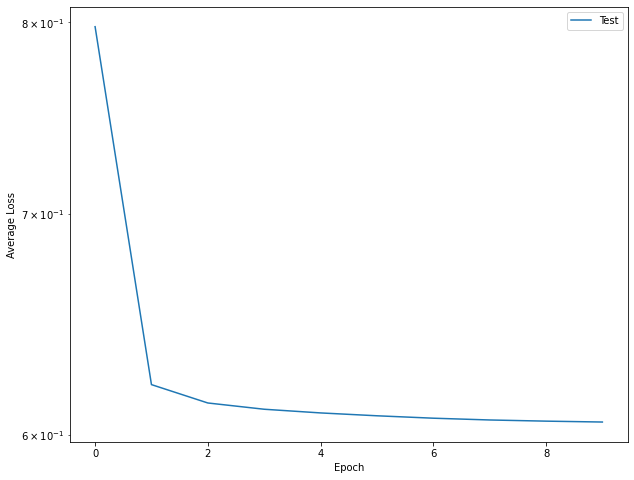

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
# plt.semilogy(encoder_loss['train_loss'], label='Train')
plt.semilogy(encoder_loss['test_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

Modifying the above ConvNet to accomodate the latent spaces produced by the trained encoder. 

In [ ]:
encoder_model = nn.Sequential(collections.OrderedDict([
                                              ('conv1', nn.Conv2d(64,64,3,padding=1)),
                                              ('relu2', nn.ReLU()),
                                              ('conv2', nn.Conv2d(64,128,3,padding=1)),
                                              ('relu3', nn.ReLU()),
                                              ('flatten', nn.Flatten()),
                                              ('Linear3', nn.Linear(128*16*16,1028)),
                                              ('relu4', nn.ReLU()),
                                              ('Linear4', nn.Linear(1028,4)),
                                              ('relu5', nn.ReLU()),
                                              ]))

In [ ]:
print("\nEncoder CNN Network Model:")
print(encoder_model)


Encoder CNN Network Model:
Sequential(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (Linear3): Linear(in_features=32768, out_features=1028, bias=True)
  (relu4): ReLU()
  (Linear4): Linear(in_features=1028, out_features=4, bias=True)
  (relu5): ReLU()
)


In [ ]:
#loading the weights of the encoder for training the smaller training dataset with the modified Convnet below
encoder = Encoder()
encoder.load_state_dict(torch.load('AutoEncoder_encoder_state.pth'))

lr =0.01

optimizer = torch.optim.SGD(encoder_model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(params_to_optimize,lr=lr, weight_decay=1e-05)

weights=torch.FloatTensor([0.71,0.71,0.88,1.00])
loss_fn = nn.CrossEntropyLoss(weight=weights)


Defining the modified train driver, which trains the training dataset on the encoder and passes its output to the above defined CNN.

In [ ]:
import datetime
epoch_print_gap = 1

def train_loop_CNN(epochs, encoder, optimizer, model, device, loss_fn, train_loader):
    model.train() 
    encoder.eval()
    for epoch in range(1, epochs + 1):
        loss_train = 0.0
        for imgs, labels,idx,path in train_loader:
            z = encoder(imgs)
            outputs = model(z)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
            

Training the new CNN and trained encoder.

In [ ]:
### Setting the random seed for reproducible results
# torch.manual_seed(0)

train_loop_CNN(epochs=EPOCHS,
                  optimizer=optimizer,
                  encoder = encoder,
                  model=encoder_model,
                  device=DEVICE,
                  loss_fn=loss_fn,
                  train_loader=train_dataloader)

2022-03-25 14:38:06.320071 Epoch 1, Training loss 18.153613448143005
2022-03-25 14:38:28.937396 Epoch 2, Training loss 14.846429467201233
2022-03-25 14:38:51.382454 Epoch 3, Training loss 13.695933282375336
2022-03-25 14:39:13.925106 Epoch 4, Training loss 9.919898211956024
2022-03-25 14:39:36.697237 Epoch 5, Training loss 10.645456463098526
2022-03-25 14:39:59.352226 Epoch 6, Training loss 7.864233195781708
2022-03-25 14:40:21.986261 Epoch 7, Training loss 8.0586097240448
2022-03-25 14:40:44.563549 Epoch 8, Training loss 6.781886428594589
2022-03-25 14:41:07.154209 Epoch 9, Training loss 7.175321966409683
2022-03-25 14:41:29.708821 Epoch 10, Training loss 7.351685106754303
2022-03-25 14:41:52.238372 Epoch 11, Training loss 6.687082827091217
2022-03-25 14:42:14.895349 Epoch 12, Training loss 6.60093879699707
2022-03-25 14:42:37.501222 Epoch 13, Training loss 7.034767001867294
2022-03-25 14:43:00.044684 Epoch 14, Training loss 6.61152246594429
2022-03-25 14:43:22.972455 Epoch 15, Traini

In [ ]:
def test_loop_encoder(model, encoder,device, test_loader):
    model.eval()
    encoder.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target,idx,path in test_loader:
            z = encoder(data)
            output = model(z)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
# test function 
def get_predictions_encoder(model, encoder, test_loader):
    model.eval()
    encoder.eval()
    test_loss,correct = 0 , 0
    targets = np.array([])
    paths=np.array([])
    with torch.no_grad(): 
        for data in test_loader:
            # data[0] = data[0].cuda()
            inputs=data[0]
            z = encoder(inputs)
            output = model(z)
            output_submission=target_transform_label(output.argmax(dim=1,keepdim=True))
            # print("Label:",output)
            paths=np.concatenate([paths,data[2]],axis=0)
            targets=np.concatenate([targets,output_submission],axis=0)
    return paths,targets

In [ ]:
test_loop_encoder(model = encoder_model, encoder=encoder, device = device, test_loader = train_dataloader)


Training set: Average loss: 0.3943, Accuracy: 1423/1700 (84%)



In [ ]:
paths,targets=get_predictions_encoder(encoder_model, encoder,test_dataloader)

In [ ]:
save_result(paths,targets)

                Id        Type
0     tile7981.png      Cancer
1     tile7153.png      Cancer
2     tile7944.png      Cancer
3     tile6441.png  Connective
4     tile6318.png  Connective
...            ...         ...
3195  tile5576.png  Connective
3196  tile8037.png      Cancer
3197  tile7043.png      Cancer
3198  tile8114.png      Cancer
3199  tile6457.png  Connective

[3200 rows x 2 columns]


**Conclusion**

However, I believe that the autoencoder's latent space is highly irregular: adjacent points in the latent space might create quite varied and incoherent patterns over visible units.

Hence,we could see a decrease in performance of the model rather than an improvement.